In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

In [2]:
def load_images_from_folder(folder, img_size=(256,256)):
    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = load_img(path, target_size=img_size)
        img = img_to_array(img) / 255.0  # normalizar
        images.append(img)
    return np.array(images)

In [3]:
def compute_ssim(y_true, y_pred):
    return ssim((y_true * 255).astype('uint8'), (y_pred * 255).astype('uint8'), channel_axis=2)

def psnr(img1, img2):
    return cv2.PSNR((img1 * 255).astype(np.uint8), (img2 * 255).astype(np.uint8))

In [41]:
base_path = 'c:/Users/qdari/OneDrive/Documentos/aprendizajeSupervisado/planttraits2024'  ###
X = load_images_from_folder(os.path.join(base_path, 'images_original'))
Y = load_images_from_folder(os.path.join(base_path, 'images_clean'))
X_test = load_images_from_folder(os.path.join(base_path, 'images_test'))

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f'Train shape: {X_train.shape}, Validation shape: {X_val.shape}')

Train shape: (560, 256, 256, 3), Validation shape: (140, 256, 256, 3)


In [19]:
optimizer_class = 'Adam'
lr = 5e-4
optimizer = Adam(learning_rate=lr)

input_img = Input(shape=(256, 256, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)

#x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
#x = UpSampling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Capa de salida
decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)

# Modelo autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer_class, loss='mse')
autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_20 (UpSampling2D)      │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_21 (UpSampling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_22 (UpSampling2D)      │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_23 (UpSampling2D)      │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 256, 256, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,366,659 (5.21 MB)

 Trainable params: 1,366,659 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# X_train: imágenes ruidosas, Y_train: imágenes limpias
batch_size = 32

# Crear generadores sincronizados para (X, Y)
train_generator = augmenter.flow(X_train, batch_size=batch_size, seed=42)
target_generator = augmenter.flow(Y_train, batch_size=batch_size, seed=42)

# Generador combinado: entrega pares (X_aug, Y_aug)
def combined_generator(gen1, gen2):
    while True:
        yield next(gen1), next(gen2)

augmented_data = combined_generator(train_generator, target_generator)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento con imágenes aumentadas
autoencoder.fit(
    augmented_data,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, Y_val),
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - loss: 0.0879 - val_loss: 0.0640
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.0650 - val_loss: 0.0628
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0597 - val_loss: 0.0633
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0640 - val_loss: 0.0603
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.0558 - val_loss: 0.0586
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.0597 - val_loss: 0.0570
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0573 - val_loss: 0.0577
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.0554 - val_loss: 0.0548
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.0511 - val_loss: 0.0545
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0517 - val_loss: 0.0494
Epoch 11/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0455 - val_loss: 0.0464
Epoch 12/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0439 - val_lo

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step


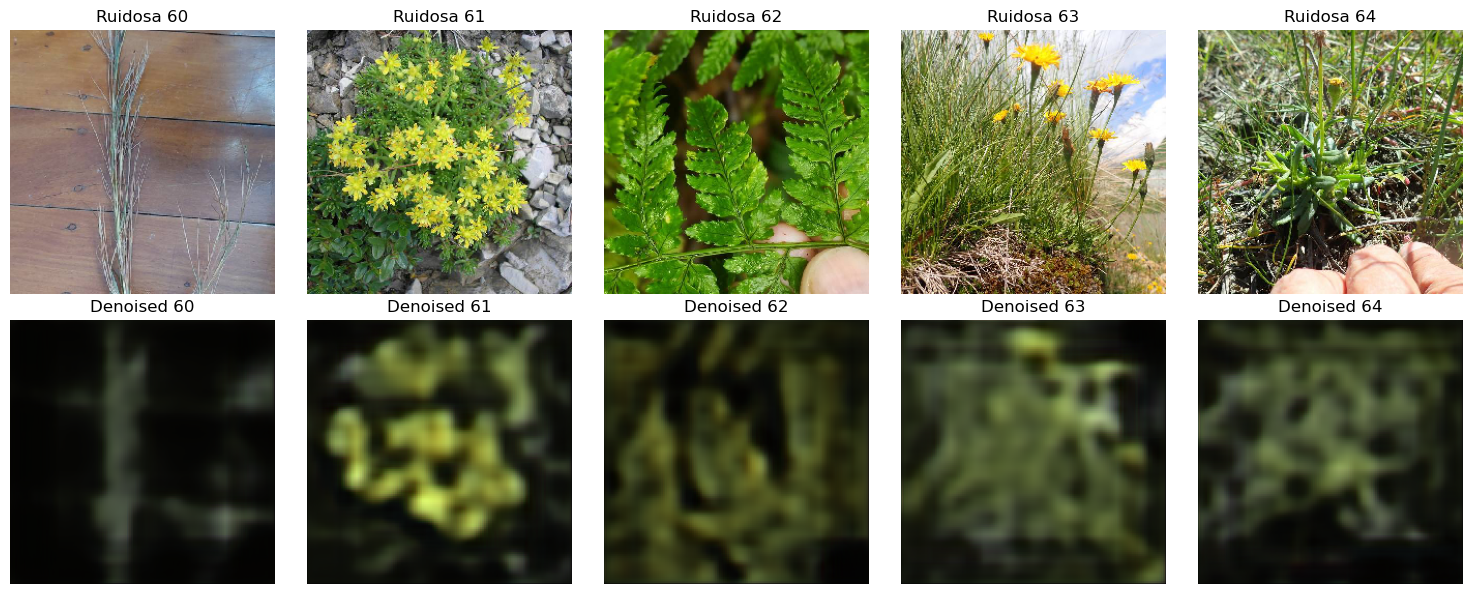

In [21]:
start_index = 60

X_test = load_images_from_folder(os.path.join(base_path, 'images_test'), img_size=(256,256))
X_denoised = autoencoder.predict(X_test)

n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
    idx = start_index + i
    if idx >= len(X_test):
        break
    ax = plt.subplot(2, n, i + 1)  # Imagen ruidosa
    plt.imshow(X_test[idx])
    plt.title(f"Ruidosa {idx}")
    plt.axis("off")
    ax = plt.subplot(2, n, i + 1 + n)  # Imagen denoised
    plt.imshow(X_denoised[idx])
    plt.title(f"Denoised {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error
import numpy as np

Y_test = load_images_from_folder(os.path.join(base_path, 'images_clean'), img_size=(256,256))
Y_denoised = autoencoder.predict(Y_test)

mse_values = [mean_squared_error(x_true.flatten(), x_pred.flatten())
              for x_true, x_pred in zip(Y_test, Y_denoised)]

print(f"MSE promedio en prueba: {np.mean(mse_values):.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 417ms/step
MSE promedio en prueba: 0.0236


In [24]:
ssim_val = np.mean([compute_ssim(y, yp) for y, yp in zip(Y_test, Y_denoised)])
print(f"SSIM promedio: {np.mean(ssim_val):.2f}")

psnr_val = np.mean([psnr(y, yp) for y, yp in zip(Y_test, Y_denoised)])
print(f"PSNR promedio: {np.mean(psnr_val):.2f} dB")

SSIM promedio: 0.34
PSNR promedio: 17.00 dB


In [35]:
#results = []

optimizer_class = 'Adam'
lr = 5e-4
batch_size = 16
base_filters = 64
optimizer = Adam(learning_rate=lr)

input_img = Input(shape=(256,256, 3))
x = Conv2D(base_filters, (3, 3), padding='same')(input_img)
x = LeakyReLU(negative_slope=0.01)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*2, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*4, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*8, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*8, (3, 3), padding='same')(encoded)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*4, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*2, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), padding='same')(x)
decoded = LeakyReLU(negative_slope=0.01)(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer_class, loss='mse')

In [36]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

autoencoder.fit(
    X_train, Y_train,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, Y_val),
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - loss: 0.4005 - val_loss: 0.0568
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - loss: 0.0595 - val_loss: 0.0646
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - loss: 0.0600 - val_loss: 0.0687
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - loss: 0.0588 - val_loss: 0.0601
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - loss: 0.0570 - val_loss: 0.0571
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - loss: 0.0498 - val_loss: 0.0560
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - loss: 0.0536 - val_loss: 0.0492
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - loss: 0.0486 - val_loss: 0.0458
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - loss: 0.0468 - val_loss: 0.0476
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - loss: 0.0463 - val_loss: 0.0515
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - loss: 0.0443 - val_loss: 0.0443
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - loss: 0.0

In [42]:
X_den = autoencoder.predict(X_test, verbose=0)
#X_den = (X_den -X_den.min()) / (X_den.max() - X_den.min())

mse = np.mean([mean_squared_error(y.flatten(), yp.flatten()) for y, yp in zip(X_test, X_den)])
psnr_val = np.mean([psnr(y, yp) for y, yp in zip(X_test, X_den)])
ssim_val = np.mean([compute_ssim(y, yp) for y, yp in zip(X_test, X_den)])

results = []

results.append({
    'trial': 0,
    'optimizer': optimizer_class,
    'learning_rate': lr,
    'batch_size': batch_size,
    'filters': base_filters,
    'MSE': mse,
    'PSNR': psnr_val,
    'SSIM': ssim_val
})

In [43]:
df_results = pd.DataFrame(results)
print(df_results.sort_values(by='PSNR', ascending=False))

   trial optimizer  learning_rate  batch_size  filters       MSE       PSNR  \
0      0      Adam         0.0005          16       64  0.115736  10.005897   

       SSIM  
0  0.120281  


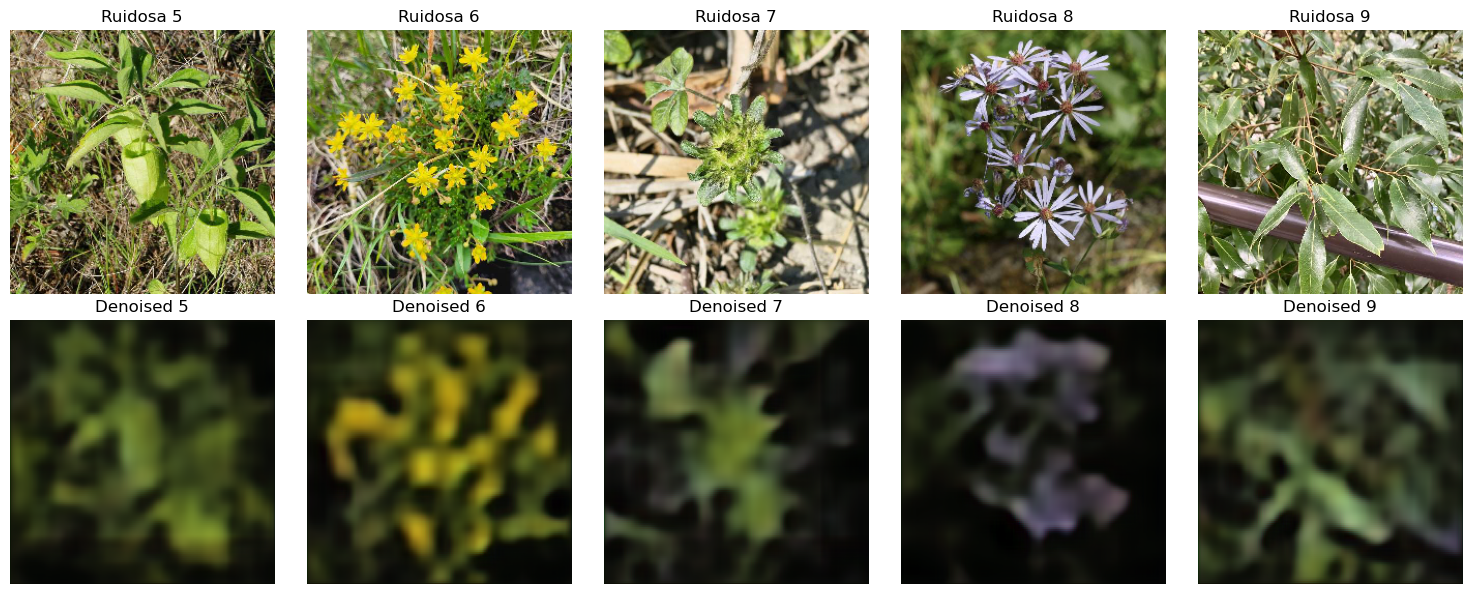

In [47]:
X_den = (X_den -X_den.min()) / (X_den.max() - X_den.min())
start_index = 5

n = 5  # número de imágenes a mostrar
plt.figure(figsize=(15, 6))
for i in range(n):
    idx = start_index + i
    if idx >= len(X_den):
        break
    ax = plt.subplot(2, n, i + 1)  # Imagen ruidosa
    plt.imshow(X_test[idx])
    plt.title(f"Ruidosa {idx}")
    plt.axis("off")
    ax = plt.subplot(2, n, i + 1 + n)  # Imagen denoised
    plt.imshow(X_den[idx])
    plt.title(f"Denoised {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [48]:
optimizer_class = 'Adam'
lr = 1e-3
optimizer = Adam(learning_rate=lr)

input_img = Input(shape=(256, 256, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)

#x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
#x = UpSampling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Capa de salida
decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)

# Modelo autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer_class, loss='mse')

In [49]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

autoencoder.fit(
    X_train, Y_train,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, Y_val),
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 831ms/step - loss: 0.0800 - val_loss: 0.0633
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 812ms/step - loss: 0.0616 - val_loss: 0.0624
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 829ms/step - loss: 0.0598 - val_loss: 0.0601
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 829ms/step - loss: 0.0571 - val_loss: 0.0580
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 822ms/step - loss: 0.0553 - val_loss: 0.0631
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 826ms/step - loss: 0.0569 - val_loss: 0.0545
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 851ms/step - loss: 0.0541 - val_loss: 0.0552
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 833ms/step - loss: 0.0531 - val_loss: 0.0531
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 831ms/step - loss: 0.0512 - val_loss: 0.0526
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 835ms/step - loss: 0.0466 - val_loss: 0.0454
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 828ms/step - loss: 0.0414 - val_loss: 0.0445
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step


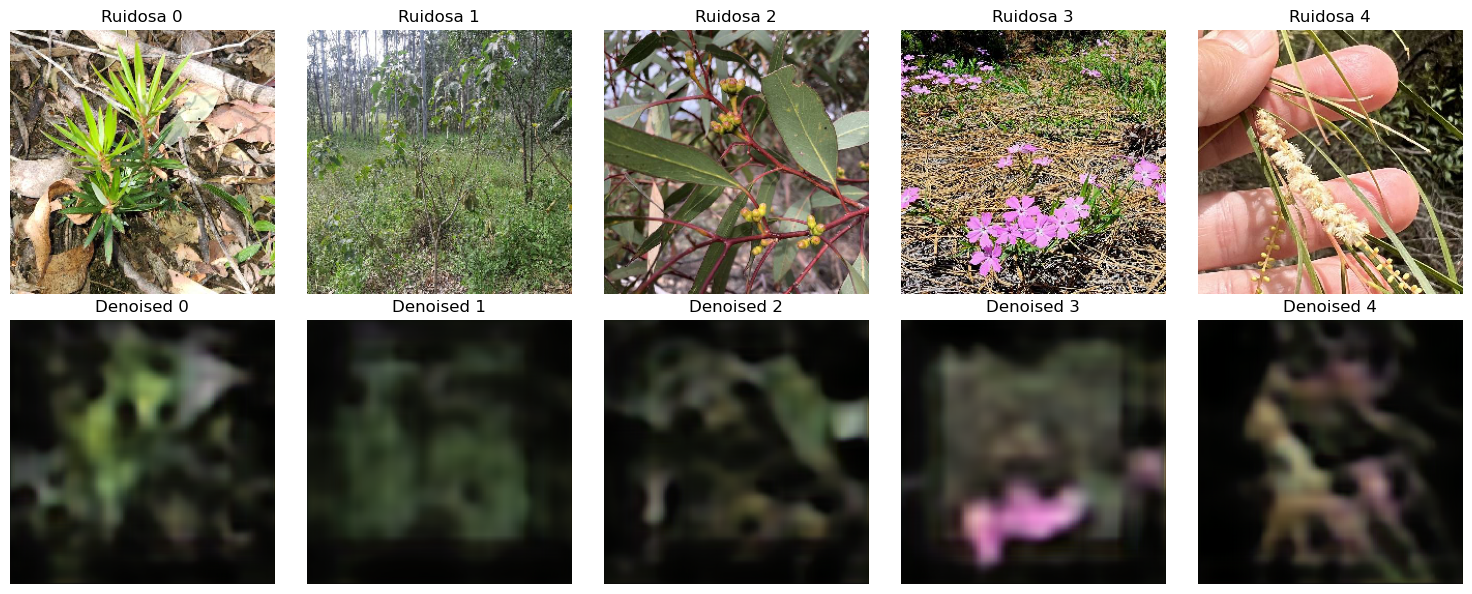

In [53]:
start_index = 0

X_test = load_images_from_folder(os.path.join(base_path, 'images_test'), img_size=(256,256))
X_den = autoencoder.predict(X_test)
X_den = (X_den -X_den.min()) / (X_den.max() - X_den.min())

n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
    idx = start_index + i
    if idx >= len(X_test):
        break
    ax = plt.subplot(2, n, i + 1)  # Imagen ruidosa
    plt.imshow(X_test[idx])
    plt.title(f"Ruidosa {idx}")
    plt.axis("off")
    ax = plt.subplot(2, n, i + 1 + n)  # Imagen denoised
    plt.imshow(X_den[idx])
    plt.title(f"Denoised {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [106]:
optimizer_class = 'Adam'
lr = 1e-3
batch_size = 16
optimizer = Adam(learning_rate=lr)
base_filters = 64

input_img = Input(shape=(256, 256, 3))

x = Conv2D(base_filters, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(base_filters*2, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(base_filters*4, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(base_filters*8, (3, 3), activation='relu')(x)
#x = MaxPooling2D((2, 2),)(x)

#x = Conv2D(base_filters*16, (3, 3), activation='relu')(x)
encoded = MaxPooling2D((2, 2))(x)

#x = Conv2D(base_filters*16, (3, 3), activation='relu', padding = "same")(encoded)
#x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*8, (3, 3), activation='relu', padding = "same")(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*4, (3, 3), activation='relu', padding = "same")(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*2, (3, 3), activation='relu', padding = "same")(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters, (3, 3), activation='relu', padding = "same")(x)
x = UpSampling2D((2, 2))(x)

# Capa de salida
decoded = Conv2D(3, (3, 3), activation='relu')(x)

# Modelo autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer_class, loss='mse')
autoencoder.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_356 (Conv2D)                  │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_161 (MaxPooling2D)     │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_357 (Conv2D)                  │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_162 (MaxPooling2D)     │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_358 (Conv2D)                  │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_163 (MaxPooling2D)     │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_359 (Conv2D)                  │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_164 (MaxPooling2D)     │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_360 (Conv2D)                  │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_161 (UpSampling2D)     │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_361 (Conv2D)                  │ (None, 28, 28, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_162 (UpSampling2D)     │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_362 (Conv2D)                  │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_163 (UpSampling2D)     │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_363 (Conv2D)                  │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_164 (UpSampling2D)     │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_364 (Conv2D)                  │ (None, 222, 222, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,461,251 (20.83 MB)

 Trainable params: 5,461,251 (20.83 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
X_ = load_images_from_folder(os.path.join(base_path, 'images_original'))
Y_ = load_images_from_folder(os.path.join(base_path, 'images_clean'), img_size = (222,222))
X_test_ = load_images_from_folder(os.path.join(base_path, 'images_test'))

X_train_, X_val_, Y_train_, Y_val_ = train_test_split(X_, Y_, test_size=0.2)

In [108]:
augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Crear generadores sincronizados para (X, Y)
train_generator = augmenter.flow(X_train_, batch_size=batch_size)
target_generator = augmenter.flow(Y_train_, batch_size=batch_size)

# Generador combinado: entrega pares (X_aug, Y_aug)
def combined_generator(gen1, gen2):
    while True:
        yield next(gen1), next(gen2)

augmented_data = combined_generator(train_generator, target_generator)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento con imágenes aumentadas
autoencoder.fit(
    augmented_data,
    steps_per_epoch=len(X_train_) // batch_size,
    validation_data=(X_val_, Y_val_),
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 0.5127 - val_loss: 0.0723
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.0639 - val_loss: 0.0703
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 0.0641 - val_loss: 0.0716
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - loss: 0.0628 - val_loss: 0.0696
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 0.0638 - val_loss: 0.0746
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.0683 - val_loss: 0.0708
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 0.0636 - val_loss: 0.0706
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 0.0668 - val_loss: 0.0695
Epoch 9/30
 6/35 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - loss: 0.0632

KeyboardInterrupt: 

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step


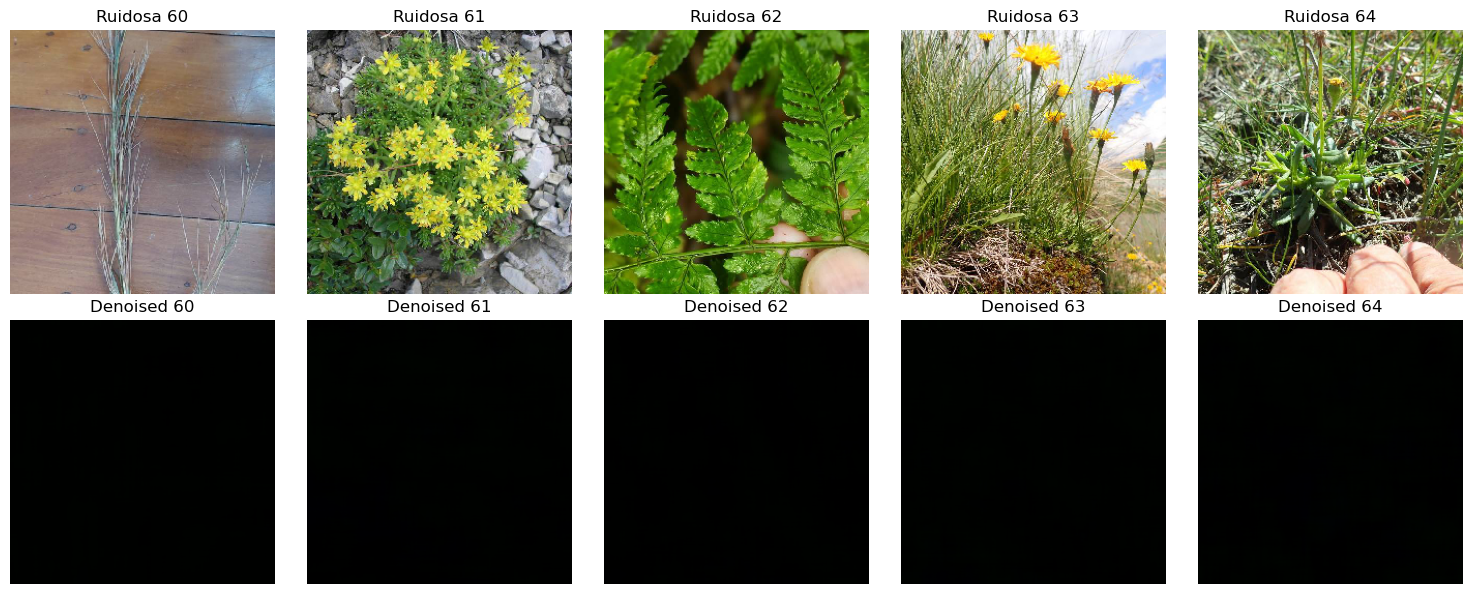

In [83]:
start_index = 60

Y_test_ = load_images_from_folder(os.path.join(base_path, 'images_clean'), img_size=(256,256))
Y_test_162 = load_images_from_folder(os.path.join(base_path, 'images_clean'), img_size=(222,222))
Y_denoised_ = autoencoder.predict(Y_test_)

n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
    idx = start_index + i
    if idx >= len(X_test_):
        break
    ax = plt.subplot(2, n, i + 1)  # Imagen ruidosa
    plt.imshow(X_test_[idx])
    plt.title(f"Ruidosa {idx}")
    plt.axis("off")
    ax = plt.subplot(2, n, i + 1 + n)  # Imagen denoised
    plt.imshow(X_denoised_[idx])
    plt.title(f"Denoised {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [84]:
mse_values = [mean_squared_error(x_true.flatten(), x_pred.flatten())
              for x_true, x_pred in zip(Y_test_162, Y_denoised_)]

print(f"MSE promedio en prueba: {np.mean(mse_values):.4f}")

MSE promedio en prueba: 0.0582


In [85]:
ssim_val = np.mean([compute_ssim(y, yp) for y, yp in zip(Y_test_162, Y_denoised_)])
print(f"SSIM promedio: {np.mean(ssim_val):.2f}")

psnr_val = np.mean([psnr(y, yp) for y, yp in zip(Y_test_162, Y_denoised_)])
print(f"PSNR promedio: {np.mean(psnr_val):.2f} dB")

SSIM promedio: 0.05
PSNR promedio: 12.94 dB


In [89]:

input_img = Input(shape=(256,256, 3))
x = Conv2D(base_filters, (3, 3), padding='same')(input_img)
x = LeakyReLU(negative_slope=0.01)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*2, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*4, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*8, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*8, (3, 3), padding='same')(encoded)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*4, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*2, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer_class, loss='mse')
autoencoder.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)   │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_275 (Conv2D)           │ (None, 254, 254, 64)      │           1,792 │ input_layer_27[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_124             │ (None, 127, 127, 64)      │               0 │ conv2d_275[0][0]           │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_276 (Conv2D)           │ (None, 125, 125, 128)     │          73,856 │ max_pooling2d_124[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_125             │ (None, 62, 62, 128)       │               0 │ conv2d_276[0][0]           │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_277 (Conv2D)           │ (None, 60, 60, 256)       │         295,168 │ max_pooling2d_125[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_126             │ (None, 30, 30, 256)       │               0 │ conv2d_277[0][0]           │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_278 (Conv2D)           │ (None, 28, 28, 512)       │       1,180,160 │ max_pooling2d_126[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_127             │ (None, 14, 14, 512)       │               0 │ conv2d_278[0][0]           │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_279 (Conv2D)           │ (None, 12, 12, 1024)      │       4,719,616 │ max_pooling2d_127[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_128             │ (None, 6, 6, 1024)        │               0 │ conv2d_279[0][0]           │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_280 (Conv2D)           │ (None, 6, 6, 1024)        │       9,438,208 │ max_pooling2d_128[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_124             │ (None, 12, 12, 1024)      │               0 │ conv2d_280[0][0]           │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_281 (Conv2D)           │ (None, 12, 12, 512)       │       4,719,104 │ up_sampling2d_124[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 21,978,371 (83.84 MB)

 Trainable params: 21,978,371 (83.84 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
autoencoder.fit(
    X_train_, Y_train_,
    steps_per_epoch=len(X_train_) // batch_size,
    validation_data=(X_val_, Y_val_),
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m2332974312784\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)\n  • training=True\n  • mask=None'